In [2]:
import nibabel as nib
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class MRIDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.image_list = [str(i).zfill(3) for i in range(21, 201) if i != 163]

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_folder = self.image_list[idx]
        t1w_path = os.path.join(self.root_dir, image_folder, 'T1w_1mm.nii.gz').replace('\\','/')
        t2w_path = os.path.join(self.root_dir, image_folder, 'T2w_align.nii.gz').replace('\\','/')
        fa_path = os.path.join(self.root_dir, image_folder, 'FA_align.nii.gz').replace('\\','/')

        t1w_image = nib.load(t1w_path).get_fdata().astype(np.float32)
        t2w_image = nib.load(t2w_path).get_fdata().astype(np.float32)
        fa_image = nib.load(fa_path).get_fdata().astype(np.float32)

        # normalizing the images to be between 0 and 1
        t1w_image = t1w_image / np.max(t1w_image)
        t2w_image = (t2w_image-np.min(t2w_image) )/ (np.max(t2w_image)-np.min(t2w_image))  
        
        # SY: t1 range [0, ~4000]
        # SY: t2 positive and negative range
        # SY: no need normalize fa and adc
        # SY: fa in [0,1], adc depends and negative and positive
        # SY: focus on the output of the model
        
        

        # converting to PyTorch tensors
        t1w_image = torch.from_numpy(t1w_image)
        t2w_image = torch.from_numpy(t2w_image)
        fa_image = torch.from_numpy(fa_image)

        # Adding a new dimension for the color channel
        t1w_image = t1w_image.unsqueeze(0)
        t2w_image = t2w_image.unsqueeze(0)
        fa_image = fa_image.unsqueeze(0)

        # concatenating T1w and T2w images into a single tensor
        t1w_t2w_image = torch.cat((t1w_image, t2w_image), dim=0)

        return t1w_t2w_image, fa_image




In [ ]:
class VMRIDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.image_list = [str(i).zfill(3) for i in range(1, 21)]

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_folder = self.image_list[idx]
        t1w_path = os.path.join(self.root_dir, image_folder, 'T1w_1mm.nii.gz').replace('\\','/')
        t2w_path = os.path.join(self.root_dir, image_folder, 'T2w_align.nii.gz').replace('\\','/')
        fa_path = os.path.join(self.root_dir, image_folder, 'FA_align.nii.gz').replace('\\','/')

        t1w_image = nib.load(t1w_path).get_fdata().astype(np.float32)
        t2w_image = nib.load(t2w_path).get_fdata().astype(np.float32)
        fa_image = nib.load(fa_path).get_fdata().astype(np.float32)

        # normalizing the images to be between 0 and 1
        t1w_image = t1w_image / np.max(t1w_image)
        t2w_image = (t2w_image-np.min(t2w_image) )/ (np.max(t2w_image)-np.min(t2w_image))  
        
        # SY: t1 range [0, ~4000]
        # SY: t2 positive and negative range
        # SY: no need normalize fa and adc
        # SY: fa in [0,1], adc depends and negative and positive
        # SY: focus on the output of the model
        
        

        # converting to PyTorch tensors
        t1w_image = torch.from_numpy(t1w_image)
        t2w_image = torch.from_numpy(t2w_image)
        fa_image = torch.from_numpy(fa_image)

        # Adding a new dimension for the color channel
        t1w_image = t1w_image.unsqueeze(0)
        t2w_image = t2w_image.unsqueeze(0)
        fa_image = fa_image.unsqueeze(0)

        # concatenating T1w and T2w images into a single tensor
        t1w_t2w_image = torch.cat((t1w_image, t2w_image), dim=0)

        return t1w_t2w_image, fa_image




In [ ]:

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.max_pool_conv = nn.Sequential(
            nn.MaxPool3d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.max_pool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()

        self.up = nn.ConvTranspose3d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffZ = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        diffX = x2.size()[4] - x1.size()[4]
        x1 = nn.functional.pad(x1, (diffX // 2, diffX - diffX // 2,
                                    diffY // 2, diffY - diffY // 2,
                                    diffZ // 2, diffZ - diffZ // 2))
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class Generator(nn.Module):
    def __init__(self, in_channels=2, out_channels=1):
        super(Generator, self).__init__()

        self.down1 = DoubleConv(in_channels, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.down4 = Down(256, 512)
        self.down5 = Down(512, 1024)

        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)

        self.out_conv = nn.Conv3d(64, out_channels, kernel_size=1)
        self.R=nn.ReLU()
        self.targetsize=(145,174,145)    # SY: change size for desired output
        
        for m in self.modules():
            if isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose3d):
                nn.init.xavier_normal_(m.weight) # SY: Xavier initialization using a normal distribution
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        #x4 = self.down4(x3)
        #x5 = self.down5(x4)
        #x = self.up1(x5, x4)
        #x = self.up2(x3, x)
        x = self.up3(x3, x2)
        x = self.up4(x, x1)
        x = self.R(self.out_conv(x)) # SY: make it into FA range [0,1]
        
        out = torch.nn.functional.interpolate(x, size=self.targetsize, mode='trilinear', align_corners=False)
        
        return out


In [ ]:
# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()
#         self.conv1 = nn.Conv3d(1, 32, kernel_size=3, stride=2, padding=1)
#         self.bn1 = nn.BatchNorm3d(32)
#         self.leaky_relu1 = nn.LeakyReLU(inplace=True)

#         self.conv2 = nn.Conv3d(32, 64, kernel_size=3, stride=2, padding=1)
#         self.bn2 = nn.BatchNorm3d(64)
#         self.leaky_relu2 = nn.LeakyReLU(inplace=True)

#         self.conv3 = nn.Conv3d(64, 128, kernel_size=3, stride=2, padding=1)
#         self.bn3 = nn.BatchNorm3d(128)
#         self.leaky_relu3 = nn.LeakyReLU(inplace=True)

#         self.conv4 = nn.Conv3d(128, 256, kernel_size=3, stride=2, padding=1)
#         self.bn4 = nn.BatchNorm3d(256)
#         self.leaky_relu4 = nn.LeakyReLU(inplace=True)

#         self.conv5 = nn.Conv3d(256, 1, kernel_size=3, stride=1, padding=0)
#         self.conv6 = nn.Conv3d(1, 1, kernel_size=(8,9,8), stride=1, padding=0)  # SY: linear operation to resize
#         self.sigmoid = nn.Sigmoid()
        
#         for m in self.modules():
#             if isinstance(m, nn.Conv3d):
#                 nn.init.xavier_normal_(m.weight) # SY: Xavier initialization using a normal distribution
#                 if m.bias is not None:
#                     m.bias.data.zero_()

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.leaky_relu1(x)

#         x = self.conv2(x)
#         x = self.bn2(x)
#         x = self.leaky_relu2(x)

#         x = self.conv3(x)
#         x = self.bn3(x)
#         x = self.leaky_relu3(x)

#         x = self.conv4(x)
#         x = self.bn4(x)
#         x = self.leaky_relu4(x)

#         x = self.conv5(x)
#         x = self.conv6(x) # pure linear translation, make a lot of negative and positive
#         x = self.sigmoid(x) # sig make it go to 0 and 1

#         return x.view(1)

Training start!


100%|██████████| 20/20 [01:24<00:00,  4.23s/it]


[1/30] --loss_T: 0.023  --loss_V: 0.014


100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


[2/30] --loss_T: 0.014  --loss_V: 0.013


100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


[3/30] --loss_T: 0.013  --loss_V: 0.012


100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


[4/30] --loss_T: 0.013  --loss_V: 0.012


100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


[5/30] --loss_T: 0.012  --loss_V: 0.012


100%|██████████| 20/20 [00:14<00:00,  1.38it/s]


[6/30] --loss_T: 0.012  --loss_V: 0.011


100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


[7/30] --loss_T: 0.011  --loss_V: 0.010


100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


[8/30] --loss_T: 0.011  --loss_V: 0.010


100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


[9/30] --loss_T: 0.010  --loss_V: 0.011


100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


[10/30] --loss_T: 0.010  --loss_V: 0.010


100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


[11/30] --loss_T: 0.010  --loss_V: 0.009


100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


[12/30] --loss_T: 0.009  --loss_V: 0.009


100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


[13/30] --loss_T: 0.009  --loss_V: 0.010


100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


[14/30] --loss_T: 0.009  --loss_V: 0.009


100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


[15/30] --loss_T: 0.009  --loss_V: 0.009


100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


[16/30] --loss_T: 0.009  --loss_V: 0.009


100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


[17/30] --loss_T: 0.009  --loss_V: 0.008


100%|██████████| 20/20 [00:15<00:00,  1.33it/s]


[18/30] --loss_T: 0.009  --loss_V: 0.008


100%|██████████| 20/20 [00:14<00:00,  1.38it/s]


[19/30] --loss_T: 0.009  --loss_V: 0.008


100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


[20/30] --loss_T: 0.009  --loss_V: 0.009


100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


[21/30] --loss_T: 0.008  --loss_V: 0.009


100%|██████████| 20/20 [00:14<00:00,  1.38it/s]


[22/30] --loss_T: 0.008  --loss_V: 0.009


100%|██████████| 20/20 [00:14<00:00,  1.38it/s]


[23/30] --loss_T: 0.008  --loss_V: 0.008


100%|██████████| 20/20 [00:14<00:00,  1.39it/s]


[24/30] --loss_T: 0.008  --loss_V: 0.008


100%|██████████| 20/20 [00:14<00:00,  1.38it/s]


[25/30] --loss_T: 0.008  --loss_V: 0.008


100%|██████████| 20/20 [00:14<00:00,  1.38it/s]


[26/30] --loss_T: 0.008  --loss_V: 0.008


100%|██████████| 20/20 [00:14<00:00,  1.39it/s]


[27/30] --loss_T: 0.008  --loss_V: 0.009


100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


[28/30] --loss_T: 0.008  --loss_V: 0.008


100%|██████████| 20/20 [00:14<00:00,  1.39it/s]


[29/30] --loss_T: 0.008  --loss_V: 0.008


100%|██████████| 20/20 [00:14<00:00,  1.39it/s]

[30/30] --loss_T: 0.008  --loss_V: 0.008
[0.023278657346963882, 0.013656946830451488, 0.012806877493858337, 0.012933721765875816, 0.01201250683516264, 0.011640551500022411, 0.011060456745326519, 0.010542741045355797, 0.01028127409517765, 0.01011356059461832, 0.009703726507723331, 0.009336409159004688, 0.009397444315254688, 0.009273857809603214, 0.009076699614524841, 0.008950035087764263, 0.008710677735507488, 0.008637494407594204, 0.008762049488723278, 0.00856027752161026, 0.008331005461513996, 0.0083651477470994, 0.008370812050998211, 0.00841517373919487, 0.0080416239798069, 0.008062941022217274, 0.008111817762255669, 0.008021028712391853, 0.00795215368270874, 0.007917031645774841]
[0.013983155600726604, 0.013106293976306915, 0.012057985179126263, 0.011648211628198624, 0.011931492015719414, 0.010945525951683521, 0.01033959724009037, 0.010410213842988014, 0.011410534381866455, 0.009745722636580467, 0.00931877363473177, 0.009378412738442421, 0.009557142853736877, 0.009151456877589226, 0

Text(0, 0.5, 'Loss')

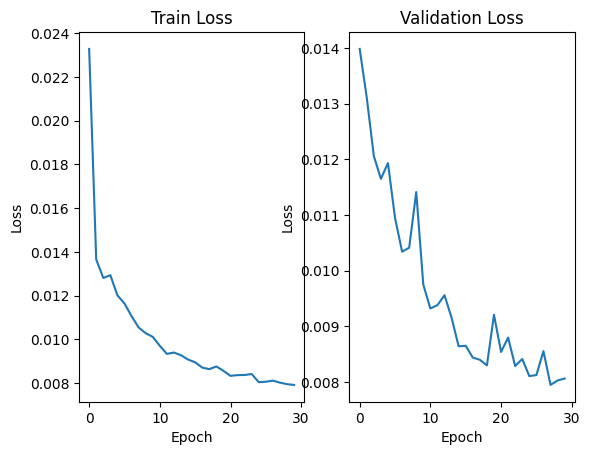

In [ ]:
mri_dataset = MRIDataset('/content/drive/MyDrive/Shuyuan/Train/') # SY: position
validset = VMRIDataset('/content/drive/MyDrive/Shuyuan/Validation/')##

batch_size = 1
mri_dataloader = DataLoader(mri_dataset, batch_size=batch_size, shuffle=True)
validLoader = DataLoader(validset, batch_size=batch_size, shuffle=True)##
gpu_boole = torch.cuda.is_available()
epochs = 30
lr_g = 0.001


G = Generator().cuda()

G_optimizer = optim.Adam(G.parameters(), lr=lr_g)
Pixel_loss = nn.L1Loss() 

#training loop:

total_G_losses = []
total_V_losses = []##
print("Training start!")


for epoch in range(epochs):

    G_losses = []
    V_losses = []



    for i, (t,f) in enumerate(tqdm(mri_dataloader)):

        t = t.cuda()
        f = f.cuda()
        
        # Step 1 calculate a new z_ and get prediction of fake data generated by 
        # generator based on z_
        G_result_1 = G(t)
        G_train_loss =  Pixel_loss(G_result_1, f)  
        # SY: BCE + weight * pixel-wise L2 loss
            

        # Step 2 calculate the train loss for generator and update weight 
        G.zero_grad()
        G_train_loss.backward()
        G_optimizer.step()
        G_losses.append(G_train_loss.data.item())
    total_G_losses.append(torch.mean(torch.FloatTensor(G_losses)).data.item())
    torch.save(G.state_dict(), '/content/drive/MyDrive/Shuyuan/FAunet_w/G%d.pth'%(epoch+1))



    with torch.no_grad():
      for i, (t,f) in enumerate(tqdm(validLoader)):

          t = t.cuda()
          f = f.cuda()
          
          # Step 1 calculate a new z_ and get prediction of fake data generated by 
          # generator based on z_
          G_result = G(t)
          G_valid_loss =  Pixel_loss(G_result, f)  
          # SY: BCE + weight * pixel-wise L2 loss
              

          # Step 2 calculate the train loss for generator and update weight 
          V_losses.append(G_valid_loss.data.item())
    total_V_losses.append(torch.mean(torch.FloatTensor(V_losses)).data.item())

    
    print('[%d/%d] --loss_T: %.3f  --loss_V: %.3f' % ((epoch + 1), epochs, torch.mean(torch.FloatTensor(G_losses)), torch.mean(torch.FloatTensor(V_losses))))

print(total_G_losses)
print(total_V_losses)


plt.subplot(1, 2, 1)
plt.plot(total_G_losses)
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(total_V_losses)
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")


In [ ]:
rank=np.array([0.013983155600726604, 0.013106293976306915, 0.012057985179126263, 0.011648211628198624, 0.011931492015719414, 0.010945525951683521, 0.01033959724009037, 0.010410213842988014, 0.011410534381866455, 0.009745722636580467, 0.00931877363473177, 0.009378412738442421, 0.009557142853736877, 0.009151456877589226, 0.00863963458687067, 0.008647836744785309, 0.00843645166605711, 0.008396541699767113, 0.00829632394015789, 0.00920453853905201, 0.008537804707884789, 0.00879506953060627, 0.008284243755042553, 0.008410345762968063, 0.008103606291115284, 0.008121956139802933, 0.00855227280408144, 0.007944727316498756, 0.008024892769753933, 0.008059382438659668]
)
print('min epoch %d'%(np.argmin(rank)+1))

#28

Text(0, 0.5, 'Loss')

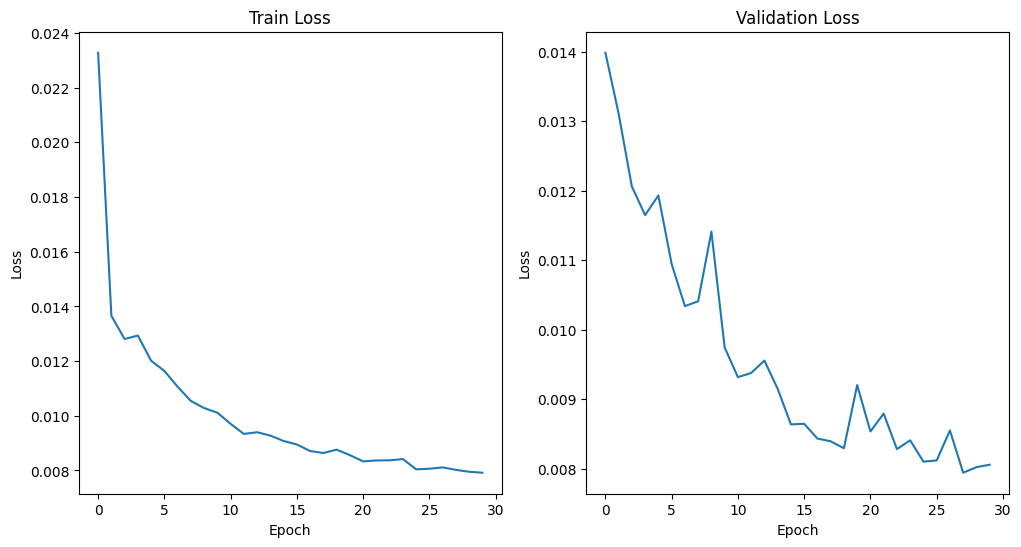

In [3]:
total_G_losses=[0.023278657346963882, 0.013656946830451488, 0.012806877493858337, 0.012933721765875816, 0.01201250683516264, 0.011640551500022411, 0.011060456745326519, 0.010542741045355797, 0.01028127409517765, 0.01011356059461832, 0.009703726507723331, 0.009336409159004688, 0.009397444315254688, 0.009273857809603214, 0.009076699614524841, 0.008950035087764263, 0.008710677735507488, 0.008637494407594204, 0.008762049488723278, 0.00856027752161026, 0.008331005461513996, 0.0083651477470994, 0.008370812050998211, 0.00841517373919487, 0.0080416239798069, 0.008062941022217274, 0.008111817762255669, 0.008021028712391853, 0.00795215368270874, 0.007917031645774841]

total_V_losses=[0.013983155600726604, 0.013106293976306915, 0.012057985179126263, 0.011648211628198624, 0.011931492015719414, 0.010945525951683521, 0.01033959724009037, 0.010410213842988014, 0.011410534381866455, 0.009745722636580467, 0.00931877363473177, 0.009378412738442421, 0.009557142853736877, 0.009151456877589226, 0.00863963458687067, 0.008647836744785309, 0.00843645166605711, 0.008396541699767113, 0.00829632394015789, 0.00920453853905201, 0.008537804707884789, 0.00879506953060627, 0.008284243755042553, 0.008410345762968063, 0.008103606291115284, 0.008121956139802933, 0.00855227280408144, 0.007944727316498756, 0.008024892769753933, 0.008059382438659668]



plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(total_G_losses)
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(total_V_losses)
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
